<a href="https://www.kaggle.com/code/raunitpatel/image-segmentation-using-unet?scriptVersionId=158199988" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sceneries/data/CameraMask/010841.png
/kaggle/input/sceneries/data/CameraMask/018431.png
/kaggle/input/sceneries/data/CameraMask/007355.png
/kaggle/input/sceneries/data/CameraMask/002712.png
/kaggle/input/sceneries/data/CameraMask/002312.png
/kaggle/input/sceneries/data/CameraMask/018421.png
/kaggle/input/sceneries/data/CameraMask/011054.png
/kaggle/input/sceneries/data/CameraMask/002735.png
/kaggle/input/sceneries/data/CameraMask/017731.png
/kaggle/input/sceneries/data/CameraMask/049288.png
/kaggle/input/sceneries/data/CameraMask/010861.png
/kaggle/input/sceneries/data/CameraMask/022240.png
/kaggle/input/sceneries/data/CameraMask/015020.png
/kaggle/input/sceneries/data/CameraMask/014385.png
/kaggle/input/sceneries/data/CameraMask/022247.png
/kaggle/input/sceneries/data/CameraMask/011480.png
/kaggle/input/sceneries/data/CameraMask/008818.png
/kaggle/input/sceneries/data/CameraMask/006884.png
/kaggle/input/sceneries/data/CameraMask/011772.png
/kaggle/input/sceneries/data/Ca

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torchvision
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [4]:
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,3,1,1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
        
        nn.Conv2d(out_channels,out_channels,3,1,1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
        )
    def forward(self,x):
        return self.conv(x)

In [5]:

import torch.nn.functional as F


class UNET(nn.Module):
    def __init__(
        self, in_channels, out_channels, features=[64, 128, 256, 512]
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # reverses the order of skip connections

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            # Exception case --warning--
            if x.shape != skip_connection.shape:
                 x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=False)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)


In [6]:
path = '/kaggle/input/sceneries'
image_path = os.path.join(path, 'data/CameraRGB/')  
mask_path = os.path.join(path, 'data/CameraMask/')  
image_list_orig = os.listdir(image_path)
image_list = [os.path.join(image_path, i) for i in image_list_orig]
mask_list = [os.path.join(mask_path, i) for i in image_list_orig]


/tmp/ipykernel_26/2127741555.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
/tmp/ipykernel_26/2127741555.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

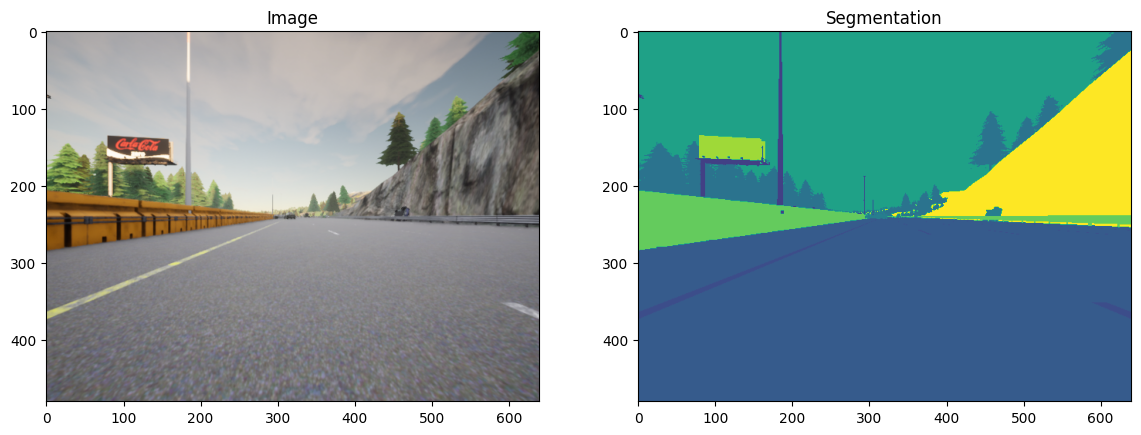

In [7]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [8]:
img.shape

(480, 640, 4)

In [9]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None, mask_transform=None):
        self.image_list = image_list
        self.mask_list = mask_list
        self.transform = transform
        self.mask_transform = mask_transform
        

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        mask_path = self.mask_list[idx]

        # Load the image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask= mask.squeeze(0)

        return image, mask

# Define the transformation with normalization and resizing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.max(x, dim=0)[0].unsqueeze(0)) 
   
])


masked_dataset = CustomDataset(image_list, mask_list, transform=transform, mask_transform=mask_transform)


In [10]:
image,mask=masked_dataset[0]

print(image.shape)
print(mask.shape)

torch.Size([3, 256, 256])
torch.Size([256, 256])


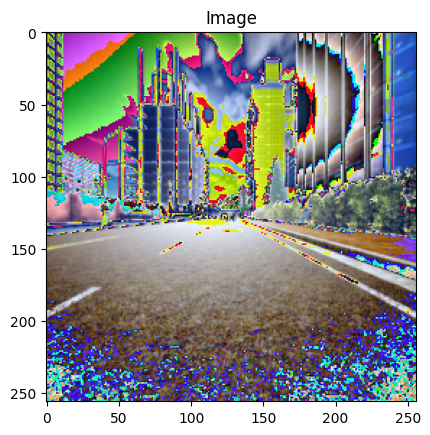

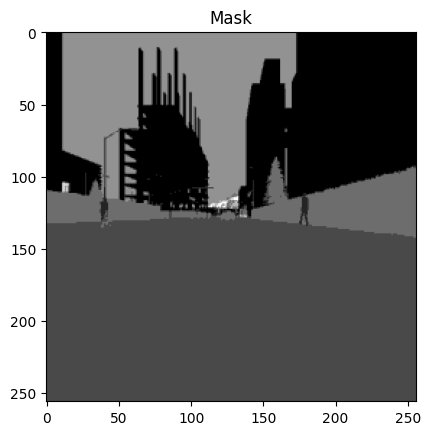

In [11]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Assuming image is a PIL Image or a PyTorch tensor, you can use the transforms
# from torchvision to convert it to a format that can be displayed by matplotlib.

# Assuming image is a tensor and needs to be converted to a PIL Image.
image_pil = TF.to_pil_image(image)

# Display the image
plt.imshow(image_pil)
plt.title('Image')
plt.show()

# Display the mask
plt.imshow(mask, cmap='gray')  # Assuming the mask is a 2D tensor
plt.title('Mask')
plt.show()


In [12]:
mask

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
        [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
        [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]])

In [13]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
train_size = 0.8  # Adjust the percentage for training set
test_size = 1 - train_size
random_seed = 42  # Set a seed for reproducibility

# Split the dataset
train_dataset, test_dataset = train_test_split(masked_dataset, test_size=test_size, random_state=random_seed)

# Create DataLoaders for training and testing
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
print(len(train_dataset),len(train_dataloader))
print(len(test_dataset))
data_iter = iter(train_dataloader)
images,targets= next(data_iter)
print(images.shape,targets.shape)

848 53
212
torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])


In [15]:
model = UNET(in_channels=3,out_channels=10)
model = model.to(device)

In [16]:
images = images.to(device)
Y_pred =model(images)
print(Y_pred.shape)

torch.Size([16, 10, 256, 256])


In [17]:
len(test_dataset)

212

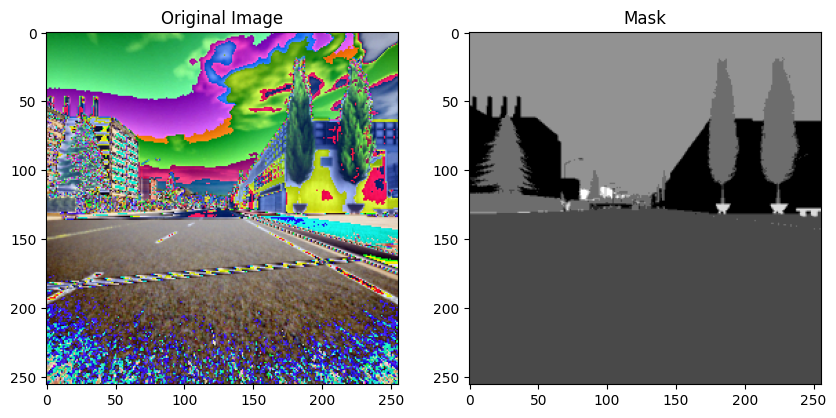

In [18]:
# Adjust the batch size based on your needs
data_loader = train_dataloader  # Choose either masked_dataloader or unmasked_dataloader

# Fetch a batch of data
batch = next(iter(data_loader))

# Unpack the batch
images, masks = batch

# Convert tensors to PIL images for display
image_to_display = torchvision.transforms.ToPILImage()(images[2])
mask_to_display = torchvision.transforms.ToPILImage()(masks[2])

# Display the original image and its mask
plt.figure(figsize=(10, 5))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(image_to_display)
plt.title("Original Image")

# Display mask
plt.subplot(1, 2, 2)
plt.imshow(mask_to_display,cmap="gray")
plt.title("Mask")

plt.show()


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm


# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of training epochs
num_epochs = 10

# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, targets in tqdm(train_dataloader,total=len(train_dataloader),leave=False):
        inputs,targets = inputs.to(device),targets.to(device)
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        # Remove the extra dimension from targets
#         targets = targets.squeeze(1).long()
        
        loss = criterion(outputs,targets.long())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        
    # Print the average training loss for the epoch
    average_loss = running_loss / len(train_dataloader)
    print(f'Training Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [1/10], Loss: 2.1069


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [2/10], Loss: 1.1778


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [3/10], Loss: 0.2744


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [4/10], Loss: 0.0747


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [5/10], Loss: 0.0363


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [6/10], Loss: 0.0223


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [7/10], Loss: 0.0153


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [8/10], Loss: 0.0113


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [9/10], Loss: 0.0087


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [10/10], Loss: 0.0069


In [20]:
model.eval()

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inp

In [21]:
X, Y = next(iter(test_dataloader))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([16, 10, 256, 256])


In [22]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

In [23]:
def create_mask(pred_mask):
    pred_mask = torch.argmax(pred_mask, dim=1)
    pred_mask = pred_mask.unsqueeze(1)
    return pred_mask
Y_pred.shape

torch.Size([16, 10, 256, 256])

In [24]:
Y_pred=create_mask(Y_pred)

In [25]:
X=inverse_transform(X[0]).permute(1,2,0).cpu().detach().numpy()
Y=Y[0].cpu().detach().numpy()
Y_p=Y_pred[0].cpu().detach().numpy()


In [26]:
print(X.shape,Y.shape,Y_p.shape)

(256, 256, 3) (256, 256) (1, 256, 256)


In [27]:
Y_p

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

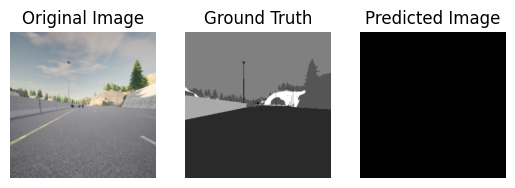

In [28]:
import matplotlib.pyplot as plt

# Assuming X, Y, and Y_pred are the variables you mentioned

# Plotting the original image (X)
plt.subplot(1, 3, 1)
plt.imshow(X)
plt.title('Original Image')
plt.axis('off')

# Plotting the ground truth (Y)
plt.subplot(1, 3, 2)
plt.imshow(Y, cmap='gray')  # Assuming Y is a grayscale image
plt.title('Ground Truth')
plt.axis('off')

# Plotting the predicted image (Y_pred)
plt.subplot(1, 3, 3)
plt.imshow(Y_p[0,:,:],cmap='gray')  # Assuming Y_pred is a grayscale image
plt.title('Predicted Image')
plt.axis('off')

# Show the plots
plt.show()
